In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.4MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 358kB 24.8MB/s 
     |████████████████████████████████| 1.0MB 31.7MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 40kB 6.2MB/s 
     |████████████████████████████████| 40kB 4.8MB/s 
     |████████████████████████████████| 92kB 12.7MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 2.6MB 60.2MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
from fastai.vision.all import *
from fastai.metrics import error_rate
import pathlib

import matplotlib.pyplot as plt 
import cv2
import numpy as np

%matplotlib inline
%reload_ext autoreload
%matplotlib inline

import torch
from torch import nn

In [4]:
!ls gdrive/'My Drive'/Projects/ASL/ASL1/asl_train

A  D	export_092320_30.pkl  G  J  M	    nothing  Q	space  V  Y
B  del	export.pkl	      H  K  models  O	     R	T      W  Z
C  E	F		      I  L  N	    P	     S	U      X


In [5]:
path = pathlib.PosixPath('gdrive/My Drive/Projects/ASL/ASL1/asl_train')
path

Path('gdrive/My Drive/Projects/ASL/ASL1/asl_train')

In [6]:
classes = ['A','B','C','D','del','E','F','G','H','I','J','K','L','M','N','nothing','O','P','Q','R','S','space','T','U','V','W','X','Y','Z']
classes

['A',
 'B',
 'C',
 'D',
 'del',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'nothing',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'space',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [7]:
data = ImageDataLoaders.from_folder(path=path, valid_pct=0.4, seed=42, item_tfms=Resize(200))

In [8]:
data.c

29

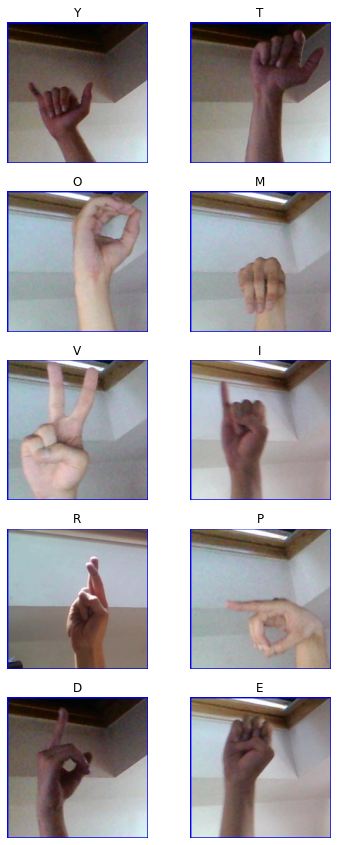

In [9]:
data.train.show_batch(max_n=10, nrows = 5)

### **Custom Head**

In [10]:
from fastai.vision.learner import cnn_config

In [11]:
def _add_norm(dls, meta, pretrained):
    if not pretrained: return
    after_batch = dls.after_batch
    if first(o for o in after_batch.fs if isinstance(o,Normalize)): return
    stats = meta.get('stats')
    if stats is None: return
    after_batch.add(Normalize.from_stats(*stats))

_default_meta    = {'cut':None, 'split':default_split}

def create_head(nf, n_out, lin_ftrs=None, ps=0.5, concat_pool=True, bn_final=False, lin_first=False, y_range=None):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, nn.Flatten()]
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

def create_cnn_model(arch, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom convnet architecture using `arch`, `n_in` and `n_out`"
    body = create_body(arch, n_in, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch`"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


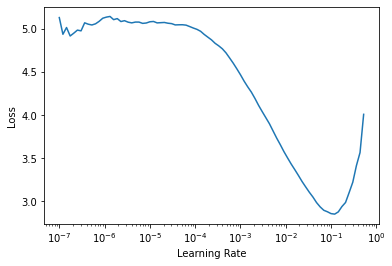

In [12]:
#Model
learn = cnn_learner(data, resnet50, metrics = error_rate)
lr_min, lr_steep = learn.lr_find()

In [14]:
learn = cnn_learner(data, resnet50, metrics = error_rate)
learn.fine_tune(2, base_lr = 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.640249,0.259962,0.066351,2:37:16


epoch,train_loss,valid_loss,error_rate,time
0,0.082081,0.020076,0.004511,03:56
1,0.028087,0.008132,0.001580,03:56


In [15]:
learn.save('ASL_092420_40')

Path('gdrive/My Drive/Projects/ASL/ASL1/asl_train/models/ASL_092420_40.pth')

In [16]:
learn.export()

Interpretation

In [18]:
learn.load('ASL_092420_40')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=1)

In [ ]:
learn.summary

# Export to ONNX

In [ ]:
learn_inf.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
learn_inf.model.eval();

In [ ]:
ONNX_path = 'gdrive/My Drive/Projects/ASL/ASL1/models/ASL092420.onnx'

In [ ]:
from torch.autograd import Variable
import torch.onnx
import torchvision

x = torch.randn(1, 3, 299, 299, requires_grad = False)
torch_out = torch.onnx._export(learn_inf.model, x, ONNX_path, export_params = True)

In [ ]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
red_scale = 1.0 / (0.229 * 255.0)
green_scale = 1.0 / (0.224 * 255.0)
blue_scale = 1.0 / (0.225 * 255.0)

args = dict(is_bgr=False, red_bias = -(0.485 * 255.0)  , green_bias = -(0.456 * 255.0)  , blue_bias = -(0.406 * 255.0))

In [ ]:
!pip install coremltools
!pip install -U onnx-coreml

Requirement already up-to-date: onnx-coreml in /usr/local/lib/python3.6/dist-packages (1.3)


In [ ]:
import copy
import coremltools
import os

from onnx import onnx_pb
from onnx_coreml import convert

In [ ]:
#model_file = open(ONNX_path, 'rb')
#model_proto = onnx_pb.ModelProto()
#model_proto.ParseFromString(model_file.read())

coreml_model = convert(
    model = ONNX_path,
    mode='classifier',
    #minimum_ios_deployment_target ='13', # to use Core ML 3
    #image_input_names = "image",
    image_input_names=['input.1'],
    class_labels='gdrive/My Drive/Projects/ASL/ASL1/alphabet_list.txt',
    preprocessing_args=args
)

1/181: Converting Node Type Conv
2/181: Converting Node Type BatchNormalization
3/181: Converting Node Type Relu
4/181: Converting Node Type MaxPool
5/181: Converting Node Type Conv
6/181: Converting Node Type BatchNormalization
7/181: Converting Node Type Relu
8/181: Converting Node Type Conv
9/181: Converting Node Type BatchNormalization
10/181: Converting Node Type Relu
11/181: Converting Node Type Conv
12/181: Converting Node Type BatchNormalization
13/181: Converting Node Type Conv
14/181: Converting Node Type BatchNormalization
15/181: Converting Node Type Add
16/181: Converting Node Type Relu
17/181: Converting Node Type Conv
18/181: Converting Node Type BatchNormalization
19/181: Converting Node Type Relu
20/181: Converting Node Type Conv
21/181: Converting Node Type BatchNormalization
22/181: Converting Node Type Relu
23/181: Converting Node Type Conv
24/181: Converting Node Type BatchNormalization
25/181: Converting Node Type Add
26/181: Converting Node Type Relu
27/181: Conv

In [ ]:
spec = coreml_model.get_spec()
nn_spec = spec.neuralNetworkClassifier
layers = nn_spec.layers # this is a list of all the layers
layers_copy = copy.deepcopy(layers) # make a copy of the layers, these will be added back later
del nn_spec.layers[:] # delete all the layers

In [ ]:
# add a scale layer now
# since mlmodel is in protobuf format, we can add proto messages directly
# To look at more examples on how to add other layers: see "builder.py" file in coremltools repo
scale_layer = nn_spec.layers.add()
scale_layer.name = 'scale_layer'
scale_layer.input.append('input.1')
scale_layer.output.append('input1_scaled')
params = scale_layer.scale
params.scale.floatValue.extend([red_scale, green_scale, blue_scale]) # scale values for RGB
params.shapeScale.extend([3,1,1]) # shape of the scale vector 

# now add back the rest of the layers (which happens to be just one in this case: the crop layer)
nn_spec.layers.extend(layers_copy)

# need to also change the input of the crop layer to match the output of the scale layer
nn_spec.layers[1].input[0] = 'input1_scaled'

In [ ]:
coreml_model = coremltools.models.MLModel(spec)

In [ ]:
coreml_path = 'gdrive/My Drive/Projects/ASL/ASL1/models/ASL1_092420_40%.mlmodel'
coreml_model.save(coreml_path)

# Production 

In [12]:
learn_inf = load_learner('gdrive/My Drive/Projects/ASL/ASL1/asl_train/models/set1_40_export.pkl')

In [13]:
learn_inf.predict('gdrive/My Drive/Projects/ASL/ASL2/asl_test2/C/C0002_test.jpg')

('C',
 tensor(2),
 tensor([2.5204e-04, 1.9271e-05, 9.9773e-01, 4.1378e-04, 1.6856e-07, 1.4500e-04, 1.0787e-05, 2.2540e-07, 2.4385e-06, 1.6250e-05, 1.1286e-05, 3.4957e-04, 5.2565e-07, 5.7982e-06, 3.5807e-05, 1.2657e-05,
         2.9562e-04, 5.5579e-05, 6.5068e-06, 3.5859e-06, 2.0938e-05, 3.6046e-07, 1.1189e-05, 4.9889e-06, 2.5145e-07, 6.0409e-06, 5.2579e-06, 7.5165e-06, 7.7053e-06, 4.9292e-06, 5.3992e-04, 2.2744e-05]))

In [14]:
learn_inf.dls.vocab

(#32) ['A','B','C','D','E','F','G','H','I','J'...]

In [15]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [16]:
btn_upload = SimpleNamespace(data = ['gdrive/My Drive/Projects/ASL/ASL2/asl_test2/Z/Z0002_test.jpg'])

In [17]:
img = PILImage.create(btn_upload.data[-1])

We can use an Output widget to display it:

In [18]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

Then we can get our predictions:

In [19]:
pred, pred_idx, probs = learn_inf.predict(img)

and use a Label to display them:

In [20]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Z; Probability: 0.8217')

Add a button to do the classification

In [21]:
#Hide output
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

Add click event handlier; a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [22]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (VBox) to complete our GUI:

In [23]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [25]:
#hide_output
VBox([widgets.Label('Show me your sign!'), 
      btn_upload, btn_run, out_pl, lbl_pred])